In [2]:
import pandas
import numpy as np
import bgshr
import os, pickle
from scipy.stats import gamma
from scipy import interpolate, optimize

In [3]:
import matplotlib, matplotlib.pylab as plt

plt.rcParams["legend.title_fontsize"] = "xx-small"
matplotlib.rc("xtick", labelsize=7)
matplotlib.rc("ytick", labelsize=7)
matplotlib.rc("axes", labelsize=8)
matplotlib.rc("axes", titlesize=8)
matplotlib.rc("legend", fontsize=6)
plt.rcParams['legend.title_fontsize'] = 'xx-small'

Combine lookup tables from moments and classic BGS scenarios.

In [4]:
df = bgshr.Util.load_lookup_table("../lookup_tables/lookup_tbl_4_epochs.csv.gz")

sstrong = -np.logspace(0, -3, 34)[:-1]
rs = np.sort(list(set(df["r"])))
gens = np.sort(list(set(df["Generation"])))
       
df_strong = bgshr.ClassicBGS.build_lookup_table_n_epoch(
    sstrong, rs, [15000, 40000, 20000, 30000], [0, 4000, 24000, 100000], 
    generations=gens, 
    uL=1e-8, uR=1e-8)
df_new = pandas.concat((df_strong, df), ignore_index=True)

In [5]:
_oob_val = 1e20

def obj_func_fixed_mu(params, data=None, verbose=False,
             lower_bound=None, upper_bound=None,
             Bvals_Ne=None, scaling=1):
    if lower_bound is None:
        lower_bound = [0 for _ in params]
    if upper_bound is None:
        upper_bound = [np.inf for _ in params]
    for p, l, u in zip(params, lower_bound, upper_bound):
        if p <= l or p >= u:
            return _oob_val
    assert len(params) == 2
    shape, scale = params
    weights = bgshr.Util.weights_gamma_dfe(s_vals, shape, scaling * scale)
    pred = bgshr.Util.integrate_with_weights(Bvals_Ne, weights[:-1], u_fac=scaling)
    ret = np.sum((pred - data) ** 2)
    if verbose:
        print(f"{func_calls}\t{params}\t{ret}")
    return ret

def obj_func_fixed_dfe(params, data=None, verbose=False,
             lower_bound=None, upper_bound=None,
             Bvals_Ne=None, scaling=1,
             shape=None, scale=None):
    if lower_bound is None:
        lower_bound = [0 for _ in params]
    if upper_bound is None:
        upper_bound = [np.inf for _ in params]
    for p, l, u in zip(params, lower_bound, upper_bound):
        if p <= l or p >= u:
            return _oob_val
    assert len(params) == 1
    u_fac = params[0]
    weights = bgshr.Util.weights_gamma_dfe(s_vals, shape, scaling * scale)
    pred = bgshr.Util.integrate_with_weights(Bvals_Ne, weights[:-1], u_fac=scaling * u_fac)
    ret = np.sum((pred - data) ** 2)
    if verbose:
        print(f"{func_calls}\t{params}\t{ret}")
    return ret

In [6]:
r = 1e-8
L = 10_000_000

def draw_elements(width=1000, n_elements=20):
    elements = []
    for _ in range(n_elements):
        center = width / 2 + np.random.rand() * (L - width)
        element = [np.max([0, int(center - width / 2)]), np.min([L, int(center + width / 2)])]
        elements.append(element)
    elements = bgshr.Util.break_up_elements(elements)
    return elements

rmap = bgshr.Util.build_uniform_rmap(r, L)

In [7]:
# DFE, from Kim et al (2017?)
shape = 0.215
scale = 0.028105
xs = np.linspace(0, L, L // 5000 + 1)

In [8]:
elements = draw_elements()
fname = f"fit_dfe.shape_{shape}.scale_{shape}_4_epochs_Kim.pkl"
print(fname)
try:
    outputs = pickle.load(open(fname, "rb"))
except IOError:
    outputs = {}
    
df_sub = df_new[df_new["Generation"] == 100000]
_, _, splines0 = bgshr.Util.generate_cubic_splines(df_sub)

print("mean, variance:", shape * scale, shape * scale ** 2)
print("ss:", [0, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1])
print("cdf:", gamma.cdf([0, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1], shape, scale=scale))
k = (shape, scale)
outputs[k] = {"fixed_mu": [], "fixed_dfe": []}

for g in gens:
    df_sub = df_new[df_new["Generation"] == g]
    
    # get predicted B values at the given generation
    _, _, splines = bgshr.Util.generate_cubic_splines(df_sub)
    s_vals = np.sort(np.unique(df_sub["s"]))
    weights = bgshr.Util.weights_gamma_dfe(s_vals, shape, scale)
    Bvals = bgshr.Predict.Bvals(xs, s_vals[:-1], splines, rmap=rmap, elements=elements)
    B = bgshr.Util.integrate_with_weights(Bvals, weights[:-1])

    # get Ne based on expected diversity at that time
    pi0 = bgshr.ClassicBGS.expected_tmrca_n_epoch_neutral([15000, 40000, 20000, 30000], [0, 100000 - g])
    Ne = pi0 / 2
    print(g, pi0, Ne)

    # rescale by that Ne, and build the equivalent steady-state B map
    scaling = Ne / 3e4 
    rmap_Ne = bgshr.Util.build_uniform_rmap(r * scaling, L)
    Bvals_Ne = bgshr.Predict.Bvals(xs, s_vals[:-1], splines0, rmap=rmap_Ne, elements=elements)

    # fit with fixed mutation rate
    p0 = [shape, scale]
    out = optimize.fmin(obj_func_fixed_mu, p0,
                        args=(B, False, None, None, Bvals_Ne, scaling),
                        disp=0)
    print("fixed mu:", out)
    outputs[k]["fixed_mu"].append(out)

    # fit with fixed DFE
    p0 = [1]
    out = optimize.fmin(obj_func_fixed_dfe, p0,
                        args=(B, False, None, None, Bvals_Ne, scaling, shape, scale),
                        disp=0)
    print("fixed dfe:", out)
    outputs[k]["fixed_dfe"].append(out)
print()
with open(fname, "wb+") as fout:
    pickle.dump(outputs, fout)

fit_dfe.shape_0.215.scale_0.215_4_epochs_Kim.pkl
mean, variance: 0.0060425750000000005 0.000169826570375
ss: [0, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1]
cdf: [0.         0.19832755 0.32518996 0.53051049 0.82563784 0.99790879
 1.        ]
0.0 31070.219800417573 15535.109900208787
fixed mu: [0.22641576 0.01313302]
fixed dfe: [1.07128906]
500.0 31088.206267969308 15544.103133984654
fixed mu: [0.224713   0.01317799]
fixed dfe: [1.06787109]
1000.0 31106.495022037197 15553.247511018599
fixed mu: [0.22300224 0.01321826]
fixed dfe: [1.06455078]
1500.0 31125.09114294831 15562.545571474155
fixed mu: [0.22134319 0.01325576]
fixed dfe: [1.06152344]
2000.0 31143.999796411354 15571.999898205677
fixed mu: [0.21983139 0.01325603]
fixed dfe: [1.05859375]
2500.0 31163.22623495166 15581.61311747583
fixed mu: [0.21854078 0.01322632]
fixed dfe: [1.05605469]
3000.0 31182.775799370225 15591.387899685113
fixed mu: [0.21739768 0.01316081]
fixed dfe: [1.05410156]
3500.0 31202.653920227312 15601.326960113656
fixed m

In [9]:
with open(fname, "wb+") as fout:
    pickle.dump(outputs, fout)

Text(0, 0.5, 'Relative mut. rate')

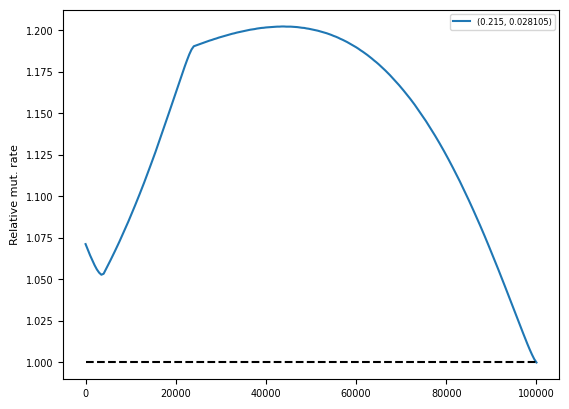

In [10]:
for k in outputs.keys():
    plt.plot(gens, outputs[k]["fixed_dfe"], label=str(k))
plt.plot(gens, np.ones(len(gens)), "k--")
plt.legend()
plt.ylabel("Relative mut. rate")

Text(0, 0.5, 'shape')

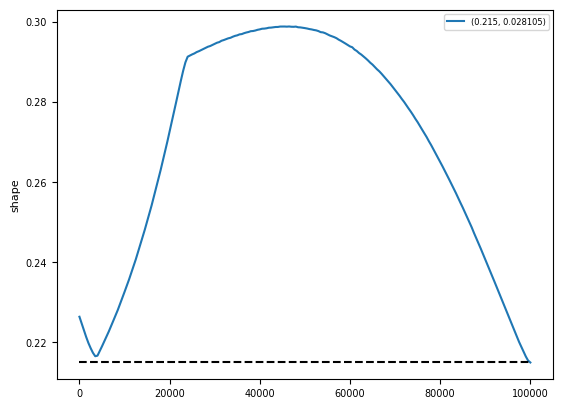

In [11]:
for k in outputs.keys():
    plt.plot(gens, np.array(outputs[k]["fixed_mu"])[:, 0], label=str(k))
plt.plot(gens, np.ones(len(gens)) * shape, "k--")
#plt.yscale("log")
plt.legend()
plt.ylabel("shape")

Text(0, 0.5, 'scale')

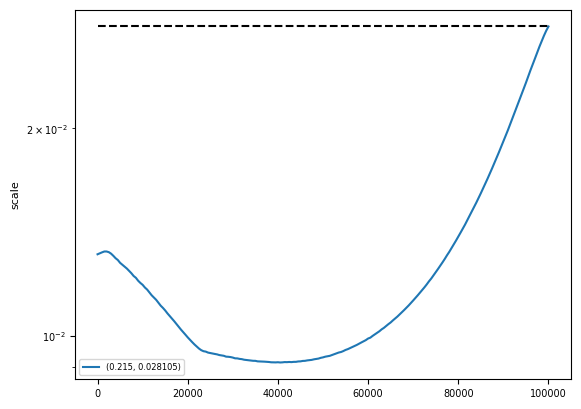

In [12]:
for k in outputs.keys():
    plt.plot(gens, np.array(outputs[k]["fixed_mu"])[:, 1], label=str(k))
plt.plot(gens, np.ones(len(gens)) * scale, "k--")
plt.yscale("log")
plt.legend()
plt.ylabel("scale")

Text(0, 0.5, 'E[s]')

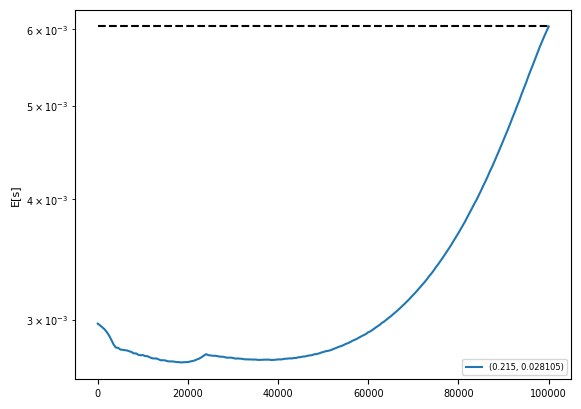

In [13]:
for k in outputs.keys():
    plt.plot(gens, np.array(outputs[k]["fixed_mu"])[:, 0] * np.array(outputs[k]["fixed_mu"])[:, 1], label=str(k))

plt.plot(gens, np.ones(len(gens)) * shape * scale, "k--")
plt.yscale("log")
plt.legend()
plt.ylabel("E[s]")

Text(0, 0.5, 'Var(s)')

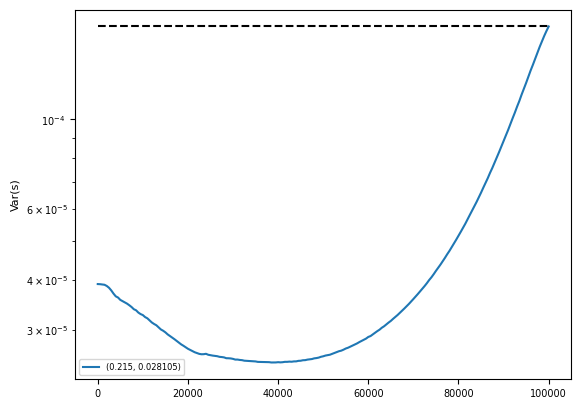

In [14]:
for k in outputs.keys():
    plt.plot(gens, np.array(outputs[k]["fixed_mu"])[:, 0] * np.array(outputs[k]["fixed_mu"])[:, 1] ** 2, label=str(k))
plt.plot(gens, np.ones(len(gens)) * shape * scale ** 2, "k--")
plt.yscale("log")
plt.legend()
plt.ylabel("Var(s)")

In [15]:
i = 0
fname = f"fit_dfe_4_epochs_Kim.{i}.pkl"
while os.path.exists(fname):
    i += 1
    fname = f"fit_dfe.{i}.pkl"
pickle.dump(outputs, open(fname, "wb+"))

In [16]:
from bokeh.palettes import Greens
colors = {}
i = 1
labels = {}
for k in outputs.keys():
    colors[k] = Greens[4][i]
    i -= 1
    labels[k] = f"{k[0]}"

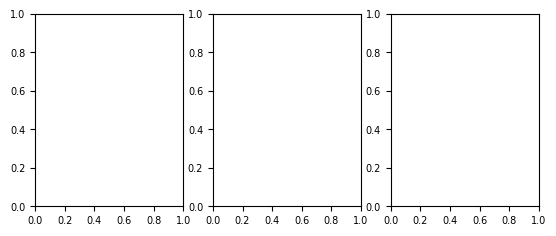

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(6.5, 2.5))

In [18]:
axes[0].clear()
for k in outputs.keys():
    axes[0].plot(gens, np.array(outputs[k]["fixed_mu"])[:, 0],
                 label=labels[k], color=colors[k])
axes[0].axhline(y=shape, linestyle='--', lw=0.75, color='gray', zorder=0)
axes[0].set_xlabel("Generations since size change")
axes[0].set_ylabel("Shape")
axes[0].set_title(r"Fixed mutation rate")
axes[0].set_yscale("log")

In [19]:
axes[1].clear()
for k in outputs.keys():
    axes[1].plot(gens, np.array(outputs[k]["fixed_mu"])[:, 1],
                 label=labels[k], color=colors[k])
axes[1].axhline(y=scale, linestyle='--', lw=0.75, color='gray', zorder=0)
axes[1].set_xlabel("Generations since size change")
axes[1].set_ylabel("Scale")
#axes[1].legend()
axes[1].set_yscale("log")
axes[1].set_title(r"Fixed mutation rate")

Text(0.5, 1.0, 'Fixed mutation rate')

In [30]:
axes[2].clear()
for k in outputs.keys():
    axes[2].plot(gens, np.array(outputs[k]["fixed_dfe"])[:, 0],
                 label=str(k), color=colors[k])
axes[2].axhline(y=1, linestyle='--', lw=1, color='gray', zorder=0)
axes[2].set_xlabel("Generations since size change")
axes[2].set_ylabel("Relative mutation rate")
axes[2].legend(handlelength=0.5, frameon=False, title=r"Kim et al. 2017", fontsize=6)
axes[2].set_title(r"Fixed DFE")
axes[2].set_ylim(top=1.3)

(0.9898828125, 1.3)

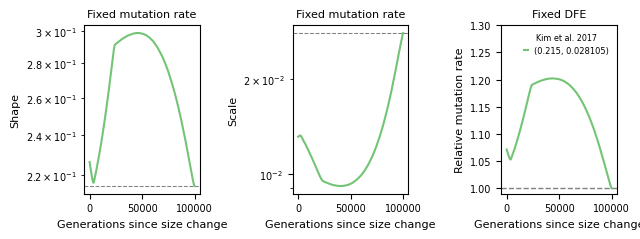

In [31]:
fig.tight_layout()
fig

In [22]:
fname = f"fit_dfe.Kim_4_epochs.pdf"
fig.savefig(fname)

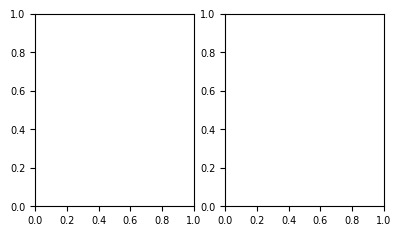

In [23]:
fig2, axes2 = plt.subplots(1, 2, figsize=(4.5, 2.5))

In [24]:
axes2[0].clear()
for k in outputs.keys():
    axes2[0].plot(gens,
                  np.array(outputs[k]["fixed_mu"])[:, 0] * np.array(outputs[k]["fixed_mu"])[:, 1],
                  label=labels[k], color=colors[k])
axes2[0].axhline(y=shape * scale, linestyle='--', lw=0.75, color='gray', zorder=0)
axes2[0].set_xlabel("Generations since size change")
axes2[0].set_ylabel("E[s]")
axes2[0].set_title(r"Fixed mutation rate")
axes2[0].set_yscale("log")

In [25]:
axes2[1].clear()
for k in outputs.keys():
    axes2[1].plot(gens,
                  np.array(outputs[k]["fixed_mu"])[:, 0] * np.array(outputs[k]["fixed_mu"])[:, 1] ** 2,
                  label=labels[k], color=colors[k])
axes2[1].axhline(y=shape * scale ** 2, linestyle='--', lw=0.75, color='gray', zorder=0)
axes2[1].set_xlabel("Generations since size change")
axes2[1].set_ylabel("Var(s)")
axes2[1].set_title(r"Fixed mutation rate")
axes2[1].set_yscale("log")

In [26]:
fig2.tight_layout()
fname = f"fit_dfe.mean_var.Kim_4_epochs.pdf"
fig2.savefig(fname)

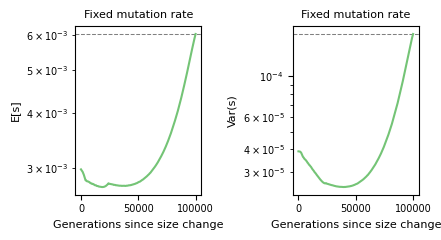

In [27]:
fig2